<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Traductor
Ejemplo basado en [LINK](https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/)

In [3]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, LSTM, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input
from keras.utils import plot_model

In [4]:
# Descargar la carpeta de dataset

import os
if os.access('spa-eng', os.F_OK) is False:
    if os.access('spa-eng.zip', os.F_OK) is False:
        !curl -L -o 'spa-eng.zip' 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip'
    !unzip -q spa-eng.zip
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [5]:
# dataset_file

text_file = "./spa-eng/spa.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]

# Por limitaciones de RAM no se leen todas las filas
MAX_NUM_SENTENCES = 6000

# Mezclar el dataset, forzar semilla siempre igual
np.random.seed([40])
np.random.shuffle(lines)

input_sentences = []
output_sentences = []
output_sentences_inputs = []
count = 0

for line in lines:
    count += 1
    if count > MAX_NUM_SENTENCES:
        break

    # el tabulador señaliza la separación entre las oraciones
    # en ambos idiomas
    if '\t' not in line:
        continue

    # Input sentence --> eng
    # output --> spa
    input_sentence, output = line.rstrip().split('\t')

    # output sentence (decoder_output) tiene <eos>
    output_sentence = output + ' <eos>'
    # output sentence input (decoder_input) tiene <sos>
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows disponibles:", len(lines))
print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows disponibles: 118964
Cantidad de rows utilizadas: 6000


### 2 - Preprocesamiento

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 8000
# Vamos a necesitar un tokenizador para cada idioma

# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.

# tokenizador de inglés
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)
# tokenizador de español
# A los filtros de símbolos del Tokenizer agregamos el "¿",
# sacamos los "<>" para que no afectar nuestros tokens
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)
# Se suma 1 para incluir el token de palabra desconocida

max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

# Por una cuestion de que no explote la RAM se limitará el tamaño de las sentencias de entrada
# a la mitad:
max_input_len = 32
max_out_len = 36

print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

#La última capa del modelo (softmax) necesita que los valores de salida del decoder (decoder_sequences) estén en formato oneHotEncoder.
# Se utiliza "decoder_output_sequences" con la misma estrategia con que se transformó la entrada del decoder.

from tensorflow.keras.utils import to_categorical
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

Palabras en el vocabulario: 3851
Sentencia de entrada más larga: 32
Palabras en el vocabulario: 5721
Sentencia de salida más larga: 36
Cantidad de rows del dataset: 6000
encoder_input_sequences shape: (6000, 32)
decoder_input_sequences shape: (6000, 36)


(6000, 36, 5722)

#### 3 - Preparar los embeddings

In [7]:
import os

if not os.access('cc.en.300.vec.gz', os.F_OK):
    !curl -o cc.en.300.vec.gz https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
if not os.access('cc.en.300.vec', os.F_OK):
    !gunzip cc.en.300.vec.gz

if not os.access('cc.es.300.vec.gz', os.F_OK):
    !curl -o cc.es.300.vec.gz https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.vec.gz
if not os.access('cc.es.300.vec', os.F_OK):
    !gunzip cc.es.300.vec.gz


In [8]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddingsEN(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext_en.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

class FasttextEmbeddingsES(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.es.300.vec'
    PKL_PATH = 'fasttext_es.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60




In [9]:
model_embeddings_en = FasttextEmbeddingsEN()
model_embeddings_es = FasttextEmbeddingsES()


In [10]:
import numpy as np

def create_embedding_matrix(word_index, embedding_model, max_vocab_size):
    """
    Crea una matriz de embeddings a partir de un diccionario de palabras y un modelo de embeddings.

    Args:
        word_index (dict): Diccionario {palabra: indice} del tokenizador.
        embedding_model (object): Instancia del modelo de embeddings (ej. FasttextEmbeddingsEN).
        max_vocab_size (int): Tamaño máximo del vocabulario permitido.

    Returns:
        np.array: Matriz de embeddings de dimensiones (nb_words, embed_dim).
    """
    print('Preparing embedding matrix...')

    # Obtener dimensión de los vectores del modelo
    embed_dim = embedding_model.N_FEATURES

    # Definir el tamaño del vocabulario (cota superior)
    # Nota: Se usa len(word_index) + 1 para asegurar cobertura si los índices empiezan en 1
    nb_words = min(max_vocab_size, len(word_index) + 1)

    # Inicializar matriz con ceros
    embedding_matrix = np.zeros((nb_words, embed_dim))

    words_not_found = []

    for word, i in word_index.items():
        # Si el índice supera el tamaño máximo definido, lo ignoramos
        if i >= nb_words:
            continue

        # Obtener el vector del modelo
        # Nota: Asumimos que get_words_embeddings devuelve una lista/array, tomamos el [0]
        embedding_vector = embedding_model.get_words_embeddings([word])[0]

        if (embedding_vector is not None) and len(embedding_vector) > 0:
            embedding_matrix[i] = embedding_vector
        else:
            words_not_found.append(word)

    # Reporte de palabras nulas (vectores de ceros)
    null_count = np.sum(np.sum(embedding_matrix**2, axis=1) == 0)
    print(f'Number of null word embeddings: {null_count}')
    print(embedding_matrix.shape)
    return embedding_matrix

print("Crear matriz para Inglés (Encoder)")
embedding_matrix_en = create_embedding_matrix(
    word_index=word2idx_inputs,
    embedding_model=model_embeddings_en,
    max_vocab_size=MAX_VOCAB_SIZE
)

print("Crear matriz para Español (Decoder)")
embedding_matrix_es = create_embedding_matrix(
    word_index=word2idx_outputs,
    embedding_model=model_embeddings_es,
    max_vocab_size=MAX_VOCAB_SIZE
)


Crear matriz para Inglés (Encoder)
Preparing embedding matrix...
Number of null word embeddings: 74
(3852, 300)
Crear matriz para Español (Decoder)
Preparing embedding matrix...
Number of null word embeddings: 62
(5722, 300)


### 4 - Entrenar el modelo

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
import tensorflow as tf

# Asumo que estas variables ya las tenés definidas arriba:
# n_units, max_input_len, nb_words, embed_dim, embedding_matrix,
# num_words_output, max_out_len

n_units = 128

# --- ENCODER ---
encoder_inputs = Input(shape=(max_input_len,), name='Encoder_Input')

encoder_embedding_layer = Embedding(
    input_dim=embedding_matrix_en.shape[0],    # Tamaño del vocabulario de entrada
    output_dim=model_embeddings_en.N_FEATURES, # Dimensión del vector denso
    weights=[embedding_matrix_en],             # Cargar pesos pre-entrenados
    trainable=False,                           # Congelar para no re-entrenar
    name='Encoder_Embedding'
)

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

# LSTM Encoder
encoder = LSTM(n_units, return_state=True, name='Encoder_LSTM')
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)

# Guardamos los estados para pasarlos al decoder (Context Vector)
encoder_states = [state_h, state_c]

# --- DECODER ---
decoder_inputs = Input(shape=(max_out_len,), name='Decoder_Input')

decoder_embedding_layer = Embedding(
    input_dim=embedding_matrix_es.shape[0],      # Tamaño del vocabulario de salida
    output_dim=model_embeddings_es.N_FEATURES,   # Dimensión 300 (FastText)
    weights=[embedding_matrix_es],               # Cargar pesos pre-entrenados (Español)
    trainable=False,                             # Congelar para no re-entrenar
    name='Decoder_Embedding'
)

decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

# LSTM Decoder
# return_sequences=True es vital aquí porque queremos la predicción palabra por palabra
decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True, name='Decoder_LSTM')

# Inicializamos el decoder con los estados del encoder
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# --- SALIDA ---
decoder_dense = Dense(num_words_output, activation='softmax', name='Output_Layer')
decoder_outputs = decoder_dense(decoder_outputs)

# --- MODELO ---
model = Model([encoder_inputs, decoder_inputs], decoder_outputs, name='Seq2Seq_Translator')

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])

model.summary()

encoder_model = Model(encoder_inputs, encoder_states)

# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)



I0000 00:00:1765671895.712878    9237 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4626 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:0a:00.0, compute capability: 7.5


Model: "Seq2Seq_Translator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Encoder_Input       │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Input       │ (None, 36)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Embedding   │ (None, 32, 300)   │  1,155,600 │ Encoder_Input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Embedding   │ (None, 36, 300)   │  1,716,600 │ Decoder_Input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_LSTM (LSTM) │ [(None, 128),     │    219,648 │ Encoder_Embeddin… │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_LSTM (LSTM) │ [(None, 36, 128), │    219,648 │ Decoder_Embeddin… │
│                     │ (None, 128),      │            │ Encoder_LSTM[0][… │
│                     │ (None, 128)]      │            │ Encoder_LSTM[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_Layer        │ (None, 36, 5722)  │    738,138 │ Decoder_LSTM[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,049,634 (15.45 MB)

 Trainable params: 1,177,434 (4.49 MB)

 Non-trainable params: 2,872,200 (10.96 MB)

In [11]:
import wandb
from wandb.integration.keras import WandbMetricsLogger

# Intentar recuperar la clave del entorno
wandb_api_key = os.getenv("WANDB_API_KEY")

if wandb_api_key:
    # Loguearse de forma no interactiva
    wandb.login(key=wandb_api_key)
    print("Logueado en WANDB exitosamente desde variable de entorno.")
else:
    # Fallback por si la variable no existe (pedirá input manual)
    raise RuntimeError("No se encontró WANDB_API_KEY en el entorno")


wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/jose/.netrc
wandb: Currently logged in as: diazjoseluis (diazjoseluis-auth0) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Logueado en WANDB exitosamente desde variable de entorno.


In [14]:
# Inicializar la run de WANDB
run = wandb.init(
    project="traductor-seq2seq-lstm", # Ponle el nombre que quieras a tu proyecto
    config={
        "epochs": 30,
        "batch_size": 32,             # El default de Keras es 32 si no lo especificas
        "n_units": n_units,           # 128
        "embedding_dim": 300,         # FastText
        "architecture": "LSTM + FastText Frozen"
    }
)

hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[WandbMetricsLogger(log_freq="batch")]
)

# Cerrar la run al terminar (opcional pero recomendado en notebooks)
wandb.finish()

2025-12-14 00:25:07.195368: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 3955046400 exceeds 10% of free system memory.
2025-12-14 00:25:10.850316: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 3955046400 exceeds 10% of free system memory.


Epoch 1/30


2025-12-14 00:25:14.216351: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7654 - loss: 4.5058

2025-12-14 00:25:29.489963: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 942.96MiB (rounded to 988761600)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-12-14 00:25:29.489997: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1049] BFCAllocator dump for GPU_0_bfc
2025-12-14 00:25:29.490007: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1056] Bin (256): 	Total Chunks: 38, Chunks in use: 36. 9.5KiB allocated for chunks. 9.0KiB in use in bin. 192B client-requested in use in bin.
2025-12-14 00:25:29.490012: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1056] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2025-12-14 00:25:29.49

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

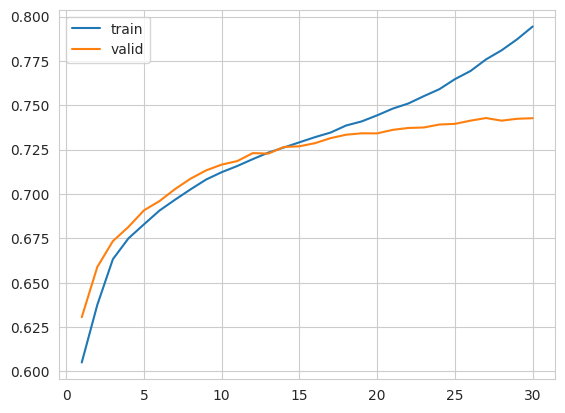

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Inferencia

In [ ]:
'''
Step 1:
A deal is a deal -> Encoder -> enc(h1,c1)

enc(h1,c1) + <sos> -> Decoder -> Un + dec(h1,c1)

step 2:
dec(h1,c1) + Un -> Decoder -> trato + dec(h2,c2)

step 3:
dec(h2,c2) + trato -> Decoder -> es + dec(h3,c3)

step 4:
dec(h3,c3) + es -> Decoder -> un + dec(h4,c4)

step 5:
dec(h4,c4) + un -> Decoder -> trato + dec(h5,c5)

step 6:
dec(h5,c5) + trato. -> Decoder -> <eos> + dec(h6,c6)
'''

In [ ]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [ ]:
def translate_sentence(input_seq):
    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [ ]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

In [ ]:
input_test = "Goodnight."
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)

### 6 - Conclusión
A primera vista parece que el modelo tendría que funcionar muy bien por el accuracy alcanzado. La realidad es que las respuestas no tienen que ver demasiado con la pregunta/traducción pero la respuesta en si tiene bastante coherencia.\
Para poder mejorar el modelo haría falta poder consumir todo el dataset y todo el vocabulario, pero la cantidad de RAM no es suficiente.\
Este problema se resuelve con:
- Utilizando un DataGenerator para no levantar todo el dataset junto en el entrenamiento.
- Transfer learning evitando tener que entrenar todo el modelo  